Topic - BERTopic Modelling Only Financial Text

#### **1. Research Background**

- This study aims to apply the **BERTopic** model to financial texts (such as tweets) for topic modelling, and to explore the relationship between topics and market performance by combining sentiment analysis and market data.
    
- The goal is to test whether the sentiment of different topics can serve as trading signals and thereby build effective trading strategies.
    

---

#### **2. Data and Methodology**

##### **Data Sources**

1. **Financial Tweet Data**:
    
    - Includes tweet texts and their sentiment scores from 2019 to 2022.
        
    - After preprocessing (e.g., removing empty tweets and time filtering), valid data was retained.
        
2. **Market Data**:
    
    - Includes technical indicators of Nvidia (NVDA), such as opening price, closing price, and trading volume.
        
    - Contains the VIX index as a market volatility factor.
        

##### **Methodology**

1. **BERTopic Model**:
    
    - Uses `SentenceTransformer` to extract text embeddings.
        
    - Applies `HDBSCAN` clustering to generate topics.
        
    - Outputs the dominant daily topic and its sentiment score.
        
2. **Sentiment and Topic Analysis**:
    
    - Calculates the average sentiment score of each daily topic.
        
    - Classifies topics into sentiment categories based on a keyword lexicon (e.g., bullish and bearish vocabularies).
        
3. **Trading Strategy**:
    
    - Generates trading signals based on topic sentiment:
        
        - use grid search to find the optimal performance
            
    - Compares the performance of topic-based strategies with the market benchmark (Buy & Hold).

## BERTopic modeling

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import warnings
import os
from tqdm import tqdm
from hdbscan import HDBSCAN
warnings.filterwarnings('ignore')

SAMPLE!!!-->too much data for CPU to handle with in HDBSCAN step...almost 1GB and 500000+ data!

In [5]:
import os
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from bertopic import BERTopic

# avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# read data
df = pd.read_csv("../2_data/financial_tweets_with_sentiment.csv", parse_dates=["Date"])
df = df.dropna(subset=['Processed_Tweet'])  
df = df[(df["Date"] >= "2019-01-01") & (df["Date"] <= "2022-12-31")].copy()
df["YearMonth"] = df["Date"].dt.to_period("M")

texts = df["Processed_Tweet"].astype(str).tolist()

texts = df["Processed_Tweet"].astype(str).tolist()
texts = list(tqdm(texts, desc="Preparing texts"))

# Step 2: Load embedded model IF YOU DON'T HAVE GPU, DROP 'DEVICE=CUDA'
embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Step 3: Define BERTopic 
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=5, metric='euclidean')
topic_model = BERTopic(
    embedding_model=embedding_model,
    language="english",
    calculate_probabilities=False, # initially not produce prob (too slow)
    verbose=True,
    nr_topics = 30
)

# Step 4: model training
topics, _ = topic_model.fit_transform(texts)
df["topic"] = topics

# check the number of topics
n_noise = (df["topic"] == -1).sum()
print(f"❗ Number of tweets that could not be categorized: {n_noise} ({n_noise / len(df):.2%})")

# filter out noise
df = df[df["topic"] != -1].reset_index(drop=True)

# store the topic model
df.to_csv("../2_data/with_BERTtopics.csv", index=False)


Preparing texts: 100%|██████████| 40557/40557 [00:00<00:00, 9335842.56it/s]
2025-05-24 16:38:47,001 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1268 [00:00<?, ?it/s]

2025-05-24 16:39:24,243 - BERTopic - Embedding - Completed ✓
2025-05-24 16:39:24,243 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-24 16:39:40,200 - BERTopic - Dimensionality - Completed ✓
2025-05-24 16:39:40,201 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-24 16:39:43,482 - BERTopic - Cluster - Completed ✓
2025-05-24 16:39:43,483 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-24 16:39:43,810 - BERTopic - Representation - Completed ✓
2025-05-24 16:39:43,811 - BERTopic - Topic reduction - Reducing number of topics
2025-05-24 16:39:43,830 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-24 16:39:44,058 - BERTopic - Representation - Completed ✓
2025-05-24 16:39:44,062 - BERTopic - Topic reduction - Reduced number of topics from 414 to 30


❗ Number of tweets that could not be categorized: 19196 (47.33%)


In [6]:
# Step 6: Results Evaluation
import matplotlib.pyplot as plt


# 1. check the topic overview
print(topic_model.get_topic_info().head(10))     # top 10 topic 
print(topic_model.get_topic(0))                  # check topic 0
# 2. check the topic distribution
fig_hierarchy = topic_model.visualize_hierarchy()
fig_hierarchy.show()

# 3. Visualize topic distribution 
fig_barchart = topic_model.visualize_barchart(top_n_topics=10)
fig_barchart.show()

fig_topics = topic_model.visualize_topics()
fig_topics.show()


topic_counts = df["topic"].value_counts()
print(topic_counts.head(10))

# 4. Visualize topics over time
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
df_clean = df.dropna(subset=["Date", "Processed_Tweet", "topic"])
docs = df_clean["Processed_Tweet"].tolist()
timestamps = df_clean["Date"].tolist()
topics = df_clean["topic"].tolist()
topics_over_time = topic_model.topics_over_time(docs, timestamps, topics=topics)
fig = topic_model.visualize_topics_over_time(topics_over_time)
fig.show()

# 5. print top 5 topics
print("\nTop 5 Topics:")
for topic_num in range(5):
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))


# 6. print top 5 topics with their keywords
topic_keywords = {}
for topic_num in df["topic"].unique():
    words = topic_model.get_topic(topic_num)
    keywords = [word for word, _ in words[:10]]
    topic_keywords[topic_num] = keywords

# 7. Manual setup of bullish / bearish keyword library (extensible)
bullish_words = {"growth", "beat", "record", "strong", "buy", "profit", "boom", "innovation", "optimism"}
bearish_words = {"loss", "fear", "fall", "crash", "bad", "bear", "cut", "warning", "down", "panic"}

# Determine the number of positive/negative sentiment words in each topic keyword
bullish_topics = []
bearish_topics = []

for topic_num, keywords in topic_keywords.items():
    score = sum(kw in bullish_words for kw in keywords) - sum(kw in bearish_words for kw in keywords)
    if score >= 1:
        bullish_topics.append(topic_num)
    elif score <= -1:
        bearish_topics.append(topic_num)

print("🐂 Bullish Topics:", bullish_topics)
print("🐻 Bearish Topics:", bearish_topics)




   Topic  Count                             Name  \
0     -1  19196         -1_nvda_stock_market_buy   
1      0  11263         0_nvda_stock_share_split   
2      1   2969      1_bullish_bear_nvda_bearish   
3      2   2021          2_upgrad_volum_nvda_gap   
4      3   1675         3_trade_amd_stock_market   
5      4   1161      4_elliottwav_updat_box_blue   
6      5    834       5_target_price_rais_nvidia   
7      6    278  6_paid_strike_sentiment_premium   
8      7    181   7_star_freedom_watchlist_watch   
9      8    112      8_time_trade_close_coinflip   

                                      Representation  \
0  [nvda, stock, market, buy, amd, go, share, lik...   
1  [nvda, stock, share, split, min, last, trade, ...   
2  [bullish, bear, nvda, bearish, bull, green, fl...   
3  [upgrad, volum, nvda, gap, downgrad, valuat, r...   
4  [trade, amd, stock, market, like, break, day, ...   
5  [elliottwav, updat, box, blue, view, area, tra...   
6  [target, price, rais, nvidia, ma

2025-05-24 16:39:47,658 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 1097) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 


topic
0    11263
1     2969
2     2021
3     1675
4     1161
5      834
6      278
7      181
8      112
9      105
Name: count, dtype: int64


1097it [00:16, 65.34it/s]



Top 5 Topics:

Topic 0:
[('nvda', np.float64(0.03706220327854983)), ('stock', np.float64(0.03581388638339962)), ('share', np.float64(0.03168900887122097)), ('split', np.float64(0.022616940185434704)), ('min', np.float64(0.0217962426298916)), ('last', np.float64(0.021262899237584516)), ('trade', np.float64(0.01850586769932879)), ('move', np.float64(0.017110440640770355)), ('nvidia', np.float64(0.016278899089561052)), ('big', np.float64(0.015425520950170123))]

Topic 1:
[('bullish', np.float64(0.09899929421202316)), ('bear', np.float64(0.05564140473951242)), ('nvda', np.float64(0.04364031074791307)), ('bearish', np.float64(0.04181191183659229)), ('bull', np.float64(0.03772151409392774)), ('green', np.float64(0.031440995318146)), ('flow', np.float64(0.024957731735032577)), ('top', np.float64(0.01920953385553554)), ('today', np.float64(0.017435368072303805)), ('rocket', np.float64(0.017182981953264037))]

Topic 2:
[('upgrad', np.float64(0.08051583828319686)), ('volum', np.float64(0.072179

# Trading Strategy

Training dates: 2019-01-02 00:00:00 to 2020-10-19 00:00:00
Validation dates: 2020-10-20 00:00:00 to 2021-05-26 00:00:00
Test dates: 2021-05-27 00:00:00 to 2021-12-31 00:00:00
Topic 0: Best thresholds on validation => positive: 0.38, negative: -0.20 ; Val Return: 8.25%
Topic 1: Best thresholds on validation => positive: 0.67, negative: -0.50 ; Val Return: 25.77%
Topic 2: Best thresholds on validation => positive: 1.00, negative: -0.84 ; Val Return: 0.12%
Topic 3: Best thresholds on validation => positive: 0.49, negative: -0.17 ; Val Return: 47.43%
Topic 4: Best thresholds on validation => positive: 0.01, negative: -0.01 ; Val Return: 1.49%
Topic 5: Best thresholds on validation => positive: 0.09, negative: -1.00 ; Val Return: 8.07%
Topic 6: Best thresholds on validation => positive: 0.01, negative: -0.01 ; Val Return: 1.49%
Topic 7: Best thresholds on validation => positive: 1.00, negative: -0.01 ; Val Return: 0.00%
Topic 8: Best thresholds on validation => positive: 0.01, negative: -0.

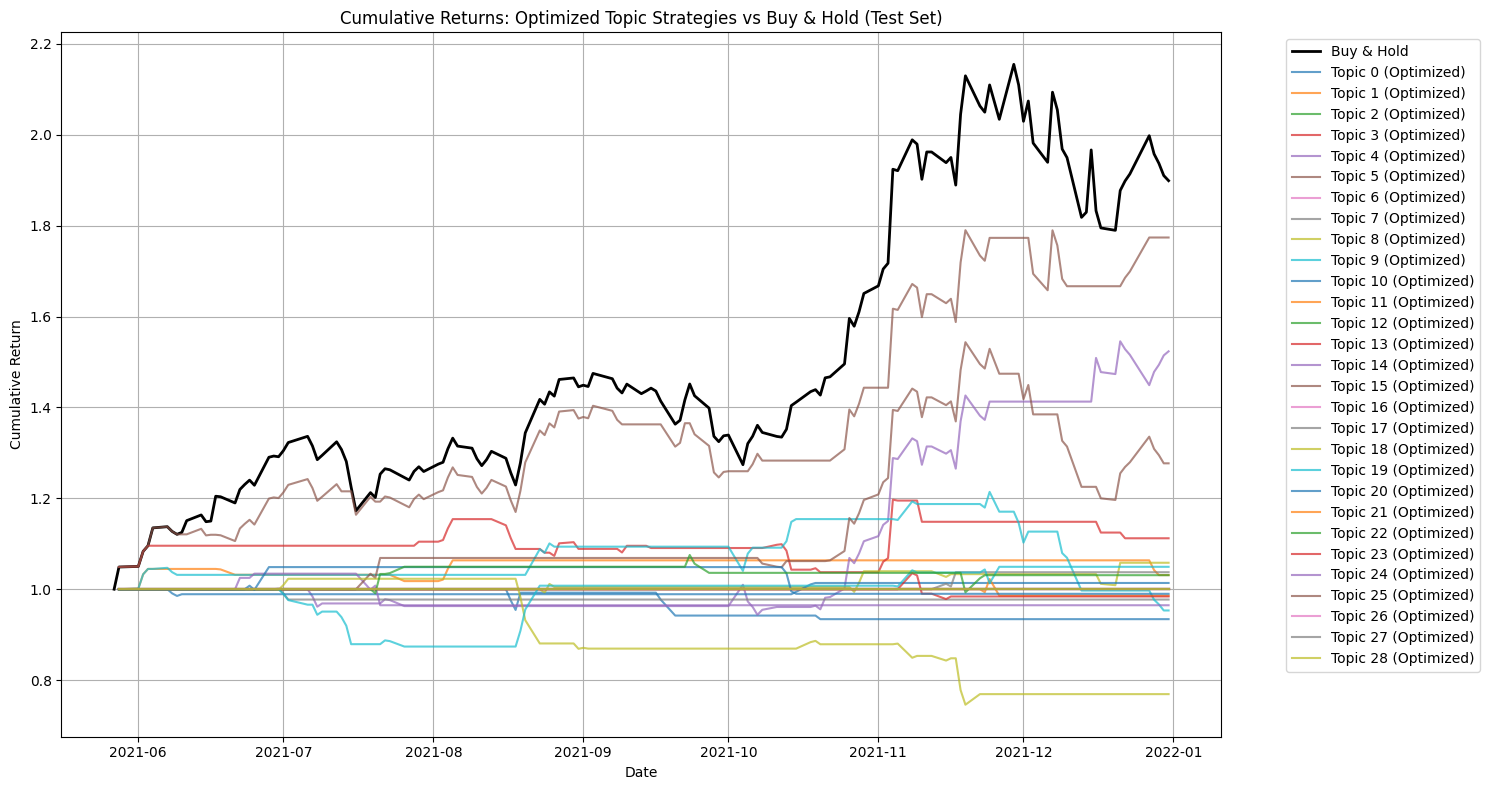

Buy & Hold (Test): 89.90%


Exception ignored in: <function ResourceTracker.__del__ at 0x104e8d1c0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1036e91c0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/m

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read aligned data
price_df = pd.read_csv('../2_data/sentiment_price_vix_inner_aligned.csv')
price_df['Date'] = pd.to_datetime(price_df['index'])
price_df = price_df.set_index('Date')

df = pd.read_csv("../2_data/with_BERTtopics.csv")
df['Date'] = pd.to_datetime(df['Date'])
daily_theme_sentiment = df.groupby(['Date', 'topic'])['sentiment_score'].mean().unstack()

# Align dates between price and sentiment data
common_dates = daily_theme_sentiment.index.intersection(price_df.index).sort_values()
daily_theme_sentiment_aligned = daily_theme_sentiment.loc[common_dates]
price_df_aligned = price_df.loc[common_dates]

# Split the data into Training (60%), Validation (20%) and Test (20%)
total_periods = len(common_dates)
train_end = int(total_periods * 0.6)
val_end = int(total_periods * 0.8)

train_dates = common_dates[:train_end]
val_dates   = common_dates[train_end:val_end]
test_dates  = common_dates[val_end:]

print(f"Training dates: {train_dates.min()} to {train_dates.max()}")
print(f"Validation dates: {val_dates.min()} to {val_dates.max()}")
print(f"Test dates: {test_dates.min()} to {test_dates.max()}")

# Define the threshold search range for grid search
positive_thresholds = np.arange(0.01, 1.01, 0.01)
negative_thresholds = -np.arange(0.01, 1.01, 0.01)

# --- Optimization on Validation Set ---
# For each topic, use the training set to compute signal and then evaluate on the validation set.
best_thresholds = {}  # Store best threshold (pos, neg) for each topic based on validation performance

# Get training and validation subsets
sentiment_train = daily_theme_sentiment_aligned.loc[train_dates]
price_train     = price_df_aligned.loc[train_dates]

sentiment_val   = daily_theme_sentiment_aligned.loc[val_dates]
price_val       = price_df_aligned.loc[val_dates]

for topic in sentiment_train.columns:
    best_return_val = -np.inf
    best_thresh = (None, None)
    # Loop over all positive/negative threshold combinations
    for pos_thresh in positive_thresholds:
        for neg_thresh in negative_thresholds:
            # Compute rolling mean signal on training set (for consistency, signal calculation is done on training window)
            # Then apply the same threshold combo on the validation set
            signal_val = sentiment_val[topic].rolling(3, min_periods=1).mean()
            position_val = (signal_val > pos_thresh).astype(int) - (signal_val < neg_thresh).astype(int)
            
            returns_val = price_val['nvda_close'].pct_change().fillna(0)
            # Skip if no valid signal points
            if position_val.dropna().empty:
                continue
            # Shift the positions to avoid lookahead bias
            strategy_returns_val = position_val.shift(1) * returns_val.loc[position_val.index]
            cum_return_val = (1 + strategy_returns_val).prod() - 1
            
            if cum_return_val > best_return_val:
                best_return_val = cum_return_val
                best_thresh = (pos_thresh, neg_thresh)
                
    best_thresholds[topic] = best_thresh
    print(f"Topic {topic}: Best thresholds on validation => positive: {best_thresh[0]:.2f}, negative: {best_thresh[1]:.2f} ; Val Return: {best_return_val:.2%}")

# --- Evaluate on Test Set using the best thresholds ---
sentiment_test  = daily_theme_sentiment_aligned.loc[test_dates]
price_test      = price_df_aligned.loc[test_dates]

# For Buy & Hold strategy on the test set
returns_test = price_test['nvda_close'].pct_change().fillna(0)
cum_returns_buy_and_hold = (1 + returns_test).cumprod()

# For each topic, compute test set performance
topic_test_returns = {}
for topic, (pos_thresh, neg_thresh) in best_thresholds.items():
    signal_test = sentiment_test[topic].rolling(3, min_periods=1).mean()
    position_test = (signal_test > pos_thresh).astype(int) - (signal_test < neg_thresh).astype(int)
    if position_test.dropna().empty:
        continue
    strategy_returns_test = position_test.shift(1) * returns_test.loc[position_test.index]
    topic_test_returns[topic] = strategy_returns_test

# Plot Buy & Hold returns and strategy returns for all topics
plt.figure(figsize=(15,8))
cum_returns_test = (1 + returns_test).cumprod()
plt.plot(cum_returns_test.index, cum_returns_test, label='Buy & Hold', color='black', linewidth=2)

for topic, returns_series in topic_test_returns.items():
    cum_strategy = (1 + returns_series).cumprod()
    plt.plot(cum_strategy.index, cum_strategy, label=f"Topic {topic} (Optimized)", alpha=0.7)
    final_return = cum_strategy.iloc[-1] - 1
    print(f"Topic {topic} (Test): {final_return:.2%}")

plt.title('Cumulative Returns: Optimized Topic Strategies vs Buy & Hold (Test Set)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Buy & Hold (Test): {(cum_returns_test.iloc[-1]-1):.2%}")